# Imports

To try:

Model on entire dataset, model uncertainty estimated by smearing entire dataset

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
print(tf.__version__)

2.2.0


In [3]:
import scipy.optimize as optimization

from BHDVCStf import BHDVCS #modified bhdvcs file
bhdvcs = BHDVCS()

# Data

In [4]:
class DvcsData(object):
    def __init__(self, df):
        self.X = df.loc[:, ['phi_x', 'k', 'QQ', 'x_b', 't', 'F1', 'F2', 'ReH', 'ReE', 'ReHtilde', 'dvcs']]
        self.XnoCFF = df.loc[:, ['phi_x', 'k', 'QQ', 'x_b', 't', 'F1', 'F2', 'dvcs']]
        self.y = df.loc[:, 'F']
        self.Kinematics = df.loc[:, ['k', 'QQ', 'x_b', 't']]
        self.erry = df.loc[:, 'errF']
        
    def __len__(self):
        return len(self.X)
    
    def getSet(self, setNum, itemsInSet=36):
        pd.options.mode.chained_assignment = None
        subX = self.X.loc[setNum*itemsInSet:(setNum+1)*itemsInSet-1, :]
        subX['F'] = self.y.loc[setNum*itemsInSet:(setNum+1)*itemsInSet-1]
        subX['errF'] = self.erry.loc[setNum*itemsInSet:(setNum+1)*itemsInSet-1]
        pd.options.mode.chained_assignment = 'warn'
        return DvcsData(subX)
    
    def sampleY(self):
        return np.random.normal(self.y, self.erry)
    
    def sampleWeights(self):
        return 1/self.erry
    
    def getAllKins(self, itemsInSets=36):
        return self.Kinematics.iloc[np.array(range(len(df)//itemsInSets))*itemsInSets, :]

In [411]:
df

,#Set,index,k,QQ,x_b,t,phi_x,F,errF,F1,F2,dvcs,ReH,ReE,ReHtilde
0,0,0,3.75,1.74013,0.435095,-0.380868,0,0.058205,0.002910,0.498060,0.68579,0.012288,13.0554,-53.0554,7.25302
1,0,1,3.75,1.74013,0.435095,-0.380868,10,0.055596,0.002780,0.498060,0.68579,0.012288,13.0554,-53.0554,7.25302
2,0,2,3.75,1.74013,0.435095,-0.380868,20,0.066353,0.003318,0.498060,0.68579,0.012288,13.0554,-53.0554,7.25302
3,0,3,3.75,1.74013,0.435095,-0.380868,30,0.068655,0.003433,0.498060,0.68579,0.012288,13.0554,-53.0554,7.25302
4,0,4,3.75,1.74013,0.435095,-0.380868,40,0.072765,0.003638,0.498060,0.68579,0.012288,13.0554,-53.0554,7.25302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,14,31,7.75,2.63258,0.345012,-0.361188,310,0.023981,0.001199,0.512913,0.71481,0.012288,11.7411,-51.7411,6.52283
536,14,32,7.75,2.63258,0.345012,-0.361188,320,0.025345,0.001267,0.512913,0.71481,0.012288,11.7411,-51.7411,6.52283
537,14,33,7.75,2.63258,0.345012,-0.361188,330,0.024191,0.001210,0.512913,0.71481,0.012288,11.7411,-51.7411,6.52283
538,14,34,7.75,2.63258,0.345012,-0.361188,340,0.020530,0.001027,0.512913,0.71481,0.012288,11.7411,-51.7411,6.52283


In [5]:
df = pd.read_csv("dvcs_xs_newsets_genCFFs.csv")
data = DvcsData(df)

In [6]:
numSets = df['#Set'].max()+1

In [7]:
numSets

15

# Produce replicas

I am using the baseline to fit replicas in this instance, but other methods can be easily substituted into the computeData function.

In [10]:
seti = data.getSet(0)
X = np.array(seti.XnoCFF)
#(df.loc[:35, 'phi_x'], df.loc[:35, 'QQ'], df.loc[:35, 'x_b'], df.loc[:35, 't'], df.loc[:35, 'k'], constants)

y = seti.sampleY()
sigma = seti.erry
pars0 = np.array([1, 1, 1]) #starting guesses for the parameters ReH, ReE, ReHTilde (in that order)

In [11]:
cff, cffcov = optimization.curve_fit(bhdvcs.TotalUUXS, X, y, pars0, sigma, method='lm')

In [14]:
numReplicas = 100

In [12]:
def computeData(numSets, numReplicas):
    results = []
    for i in tqdm(range(numSets)):
        replicas = []
        seti = data.getSet(i)
        X = np.array(seti.XnoCFF)
        sigma = seti.erry
        for i in range(numReplicas):
            y = seti.sampleY()
            cff, cffcov = optimization.curve_fit(bhdvcs.TotalUUXS, X, y, pars0, sigma, method='lm')
            replicas.append(cff)
        results.append(replicas)
    return np.array(results)

In [15]:
results = computeData(numSets, numReplicas)

100%|██████████| 15/15 [03:34<00:00, 14.28s/it]


In [414]:
df

,#Set,index,k,QQ,x_b,t,phi_x,F,errF,F1,F2,dvcs,ReH,ReE,ReHtilde
0,0,0,3.75,1.74013,0.435095,-0.380868,0,0.058205,0.002910,0.498060,0.68579,0.012288,13.0554,-53.0554,7.25302
1,0,1,3.75,1.74013,0.435095,-0.380868,10,0.055596,0.002780,0.498060,0.68579,0.012288,13.0554,-53.0554,7.25302
2,0,2,3.75,1.74013,0.435095,-0.380868,20,0.066353,0.003318,0.498060,0.68579,0.012288,13.0554,-53.0554,7.25302
3,0,3,3.75,1.74013,0.435095,-0.380868,30,0.068655,0.003433,0.498060,0.68579,0.012288,13.0554,-53.0554,7.25302
4,0,4,3.75,1.74013,0.435095,-0.380868,40,0.072765,0.003638,0.498060,0.68579,0.012288,13.0554,-53.0554,7.25302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,14,31,7.75,2.63258,0.345012,-0.361188,310,0.023981,0.001199,0.512913,0.71481,0.012288,11.7411,-51.7411,6.52283
536,14,32,7.75,2.63258,0.345012,-0.361188,320,0.025345,0.001267,0.512913,0.71481,0.012288,11.7411,-51.7411,6.52283
537,14,33,7.75,2.63258,0.345012,-0.361188,330,0.024191,0.001210,0.512913,0.71481,0.012288,11.7411,-51.7411,6.52283
538,14,34,7.75,2.63258,0.345012,-0.361188,340,0.020530,0.001027,0.512913,0.71481,0.012288,11.7411,-51.7411,6.52283


In [413]:
results.shape

(15, 100, 3)

# Examine Results

# ReH

In [394]:
pred

13.800799235205227

In [393]:
(trues[i] - pred)/pred

-0.05401130923662351

In [396]:
trues = df.loc[np.array(range(numSets))*36, 'ReH'].reset_index(drop=True)
pct_errs_locals = []

for i in range(numSets):
    pred = results[i, :, 0].mean()
    print('Set #' + str(i) + ' mean: ', pred)
    print('Set #' + str(i) + ' std: ', results[i, :, 0].std())
    print('Set #' + str(i) + ' true: ', trues[i])
    pct_errs_locals.append((trues[i] - pred)/pred)
    print('Set #' + str(i) + ' pct_err: ', pct_errs_locals[-1])
    print()

Set #0 mean:  13.800799235205227
Set #0 std:  1.072511071154321
Set #0 true:  13.0554
Set #0 pct_err:  -0.05401130923662351

Set #1 mean:  11.677016811385558
Set #1 std:  2.7614091243685293
Set #1 true:  12.5549
Set #1 pct_err:  0.07518043373530736

Set #2 mean:  6.509762702327444
Set #2 std:  2.729667045085954
Set #2 true:  7.224239999999999
Set #2 pct_err:  0.10975473766764303

Set #3 mean:  8.682071533633646
Set #3 std:  2.6607695078274665
Set #3 true:  7.6527199999999995
Set #3 pct_err:  -0.11856059117297314

Set #4 mean:  11.800206432946293
Set #4 std:  1.3020879371790532
Set #4 true:  12.5549
Set #4 pct_err:  0.0639559630877808

Set #5 mean:  6.686582038552131
Set #5 std:  1.9382663760209313
Set #5 true:  7.224239999999999
Set #5 pct_err:  0.08040848947159396

Set #6 mean:  10.170263863848666
Set #6 std:  3.203473513225569
Set #6 true:  11.7411
Set #6 pct_err:  0.1544538231436694

Set #7 mean:  9.104678432077863
Set #7 std:  2.565340214573919
Set #7 true:  7.6527199999999995
Set 

In [415]:
np.array(pct_errs_locals).mean()

0.019550454797461703

# Global Model

Shape of results = (# of Kinematic Sets, # of Replicas, 3 CFFs)

CFFs are in order of: ReH, ReE, ReHtilde

In [17]:
results.shape

(15, 100, 3)

In [341]:
kinematics = tf.keras.Input(shape=(4))
x = tf.keras.layers.Dense(20, activation="tanh")(kinematics)
outputs = tf.keras.layers.Dense(1)(x)

globalModel = tf.keras.Model(inputs=kinematics, outputs=outputs, name="GlobalModel")

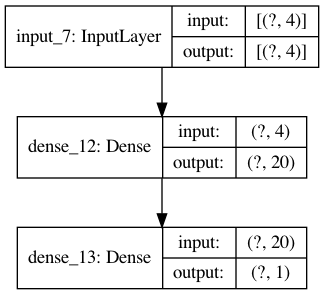

In [342]:
tf.keras.utils.plot_model(globalModel, "cffs.png", show_shapes=True)

## ReH model

In [343]:
whichCFF = 0 # ReH

In [344]:
X = df.loc[np.array(range(numSets))*36, ['k', 'QQ', 'x_b', 't']].reset_index(drop=True)

y = df.loc[np.array(range(numSets))*36, 'ReH'].reset_index(drop=True)

In [359]:
def produceEstimates(replica_models, valid_x):
    cffGuesses = []
    for model in replica_models:
        cffGuesses.append(model.predict(valid_x)[0][0])
    return np.array(cffGuesses)

In [346]:
from sklearn.preprocessing import MinMaxScaler

In [347]:
rescaler = MinMaxScaler()

In [417]:
X

,k,QQ,x_b,t
0,3.75,1.74013,0.435095,-0.380868
1,3.75,2.03646,0.415563,-0.373495
2,4.75,2.17955,0.385579,-0.283318
3,4.75,2.07387,0.436939,-0.291599
4,4.75,2.03646,0.415563,-0.373495
5,5.75,2.17955,0.385579,-0.283318
6,5.75,2.63258,0.345012,-0.361188
7,5.75,2.07387,0.436939,-0.291599
8,5.75,2.03646,0.415563,-0.373495
9,6.75,1.95072,0.360829,-0.278690


In [416]:
X_rescaled

array([[0.        , 0.        , 0.97994061, 0.        ],
       [0.        , 0.33204101, 0.76746766, 0.07215839],
       [0.25      , 0.49237492, 0.44129581, 0.95470649],
       [0.25      , 0.37395933, 1.        , 0.87366165],
       [0.25      , 0.33204101, 0.76746766, 0.07215839],
       [0.5       , 0.49237492, 0.44129581, 0.95470649],
       [0.5       , 1.        , 0.        , 0.19260506],
       [0.5       , 0.37395933, 1.        , 0.87366165],
       [0.5       , 0.33204101, 0.76746766, 0.07215839],
       [0.75      , 0.2359684 , 0.17206044, 1.        ],
       [0.75      , 0.49237492, 0.44129581, 0.95470649],
       [0.75      , 1.        , 0.        , 0.19260506],
       [1.        , 0.2359684 , 0.17206044, 1.        ],
       [1.        , 0.49237492, 0.44129581, 0.95470649],
       [1.        , 1.        , 0.        , 0.19260506]])

In [348]:
X_rescaled = rescaler.fit_transform(X)

In [350]:
globalModel.compile(optimizer=tf.keras.optimizers.Adam(.1), loss=tf.keras.losses.MeanSquaredError())

In [349]:
orig_weights = globalModel.get_weights()

In [351]:
i = 11

valid_x = X_rescaled[[i], :]
train_x = np.delete(X_rescaled, i, axis=0)
valid_y = np.array(y[i])
train_y = np.delete(np.array(y), i, axis=0)

In [352]:
valid_x

array([[0.75      , 1.        , 0.        , 0.19260506]])

In [335]:
globalModel.set_weights(orig_weights)

In [353]:
globalModel.fit(train_x, train_y, epochs = 150, verbose=2)

Epoch 1/150
1/1 - 0s - loss: 104.0302
Epoch 2/150
1/1 - 0s - loss: 70.3156
Epoch 3/150
1/1 - 0s - loss: 47.3932
Epoch 4/150
1/1 - 0s - loss: 29.9706
Epoch 5/150
1/1 - 0s - loss: 17.5446
Epoch 6/150
1/1 - 0s - loss: 10.6991
Epoch 7/150
1/1 - 0s - loss: 9.2779
Epoch 8/150
1/1 - 0s - loss: 11.4296
Epoch 9/150
1/1 - 0s - loss: 14.0019
Epoch 10/150
1/1 - 0s - loss: 14.7715
Epoch 11/150
1/1 - 0s - loss: 13.4791
Epoch 12/150
1/1 - 0s - loss: 11.0127
Epoch 13/150
1/1 - 0s - loss: 8.5088
Epoch 14/150
1/1 - 0s - loss: 6.8579
Epoch 15/150
1/1 - 0s - loss: 6.4576
Epoch 16/150
1/1 - 0s - loss: 7.1205
Epoch 17/150
1/1 - 0s - loss: 8.1964
Epoch 18/150
1/1 - 0s - loss: 8.9411
Epoch 19/150
1/1 - 0s - loss: 8.9164
Epoch 20/150
1/1 - 0s - loss: 8.1450
Epoch 21/150
1/1 - 0s - loss: 6.9914
Epoch 22/150
1/1 - 0s - loss: 5.9257
Epoch 23/150
1/1 - 0s - loss: 5.2996
Epoch 24/150
1/1 - 0s - loss: 5.2028
Epoch 25/150
1/1 - 0s - loss: 5.4483
Epoch 26/150
1/1 - 0s - loss: 5.6969
Epoch 27/150
1/1 - 0s - loss: 5.654

In [383]:
def testerWithTrue(globalModel, X, y, orig_weights, numSets):
    '''
    globalModel: a tensorflow neural network model
    X: standardized kinematic variables
    y: the true values of a CFF for each kinematic set
    orig_weights: the original weights from when the model was created (used to reset model after it has been trained)
    numSets: the number of kinematic sets
    
    returns: percent errors from each set
    '''
    pct_errors = []
    for i in range(numSets):
        valid_x = X[[i], :]
        train_x = np.delete(X, i, axis=0)
        valid_y = np.array(y[i])
        train_y = np.delete(np.array(y), i, axis=0)
        
        globalModel.set_weights(orig_weights)
        globalModel.fit(train_x, train_y, epochs = 150, verbose=0)
        print("Set #:", i)
        pred = globalModel.predict(valid_x)[0][0]
        print("Prediction: ", globalModel.predict(valid_x)[0][0])
        print("True: ", valid_y)
        pct_errors.append((valid_y - pred)/pred)
        
        print("Pct error", pct_errors[-1])
        print()
    
    return pct_errors

In [378]:
pct_errs = testerWithTrue(globalModel, X_rescaled, y, orig_weights, numSets)

Set #: 0
Prediction:  12.611219
True:  13.0554
Pct error 0.03522106622427318

Set #: 1
Prediction:  12.225933
True:  12.5549
Pct error 0.026907306218028018

Set #: 2
Prediction:  7.322303
True:  7.224239999999999
Pct error -0.013392346742787395

Set #: 3
Prediction:  7.6507916
True:  7.6527199999999995
Pct error 0.00025204645995010363

Set #: 4
Prediction:  12.2219515
True:  12.5549
Pct error 0.027241845603557212

Set #: 5
Prediction:  7.2582135
True:  7.224239999999999
Pct error -0.0046807000036856805

Set #: 6
Prediction:  12.382097
True:  11.7411
Pct error -0.05176806736513922

Set #: 7
Prediction:  7.4622693
True:  7.6527199999999995
Pct error 0.02552181997228917

Set #: 8
Prediction:  12.218863
True:  12.5549
Pct error 0.027501534247353694

Set #: 9
Prediction:  6.8670454
True:  6.990139999999999
Pct error 0.017925409001642682

Set #: 10
Prediction:  7.24019
True:  7.224239999999999
Pct error -0.002202984877480229

Set #: 11
Prediction:  12.259086
True:  11.7411
Pct error -0.04225

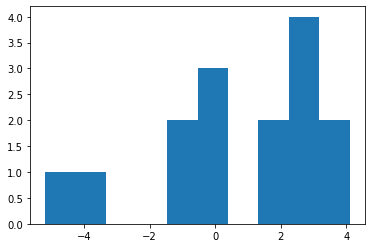

In [381]:
plt.hist(np.array(pct_errs)*100)
plt.show()

# With replicas

In [407]:
def testerWithReplicas(model, X, y, results, orig_weights, numSets, numReplicas):
    pct_errors = []
    for i in range(numSets):
        valid_x = X[[i], :]
        train_x = np.delete(X, i, axis=0)
        valid_y = np.array(y[i])
        
        preds = []
        for rep in range(numReplicas):
            train_y = np.delete(results[:, rep, whichCFF], i)
            
            model.set_weights(orig_weights)
            model.fit(train_x, train_y, epochs = 150, verbose=0)
            preds.append(model.predict(valid_x)[0][0])
        
        print("Set #: ", i)
        pred = np.array(preds).mean()
        print("Prediction: ", np.array(preds).mean())
        print("True: ", valid_y)
        print("Sigma: ", np.array(preds).std())
        pct_errors.append((valid_y - pred)/pred)
        
        print("Pct error:", pct_errors[-1])
        print()
    
    return pct_errors

In [408]:
pct_errs = testerWithReplicas(globalModel, X_rescaled, y, results, orig_weights, numSets, numReplicas)

Set #:  0
Prediction:  11.405094
True:  13.0554
Sigma:  1.9109739
Pct error 0.14469901186610243

Set #:  1
Prediction:  12.472812
True:  12.5549
Sigma:  1.1530839
Pct error 0.006581379008036809

Set #:  2
Prediction:  7.8825536
True:  7.224239999999999
Sigma:  1.215654
Pct error -0.0835152683653953

Set #:  3
Prediction:  9.091397
True:  7.6527199999999995
Sigma:  2.2128608
Pct error -0.1582460033687118

Set #:  4
Prediction:  12.378905
True:  12.5549
Sigma:  1.1304146
Pct error 0.014217307545486696

Set #:  5
Prediction:  7.4942694
True:  7.224239999999999
Sigma:  1.2976414
Pct error -0.03603144718502499

Set #:  6
Prediction:  9.436088
True:  11.7411
Sigma:  2.2892709
Pct error 0.24427628137173796

Set #:  7
Prediction:  8.742762
True:  7.6527199999999995
Sigma:  1.7753592
Pct error -0.12467932448827106

Set #:  8
Prediction:  11.463702
True:  12.5549
Sigma:  1.7309426
Pct error 0.09518720732132097

Set #:  9
Prediction:  7.229822
True:  6.990139999999999
Sigma:  1.3272328
Pct error 

In [410]:
np.corrcoef(np.abs(pct_errs), np.abs(pct_errs_locals))[1, 0]

0.31606046817588396

In [ ]:
def predictWithReplicas(model, X, y, to_pred, results, orig_weights, numSets, numReplicas):
    train_x = np.delete(X, i, axis=0)
    valid_y = np.array(y[i])

    preds = []
    for rep in range(numReplicas):
        
        train_y = results[:, rep, whichCFF]

        model.set_weights(orig_weights)
        model.fit(train_x, train_y, epochs = 150, verbose=0)
        preds.append(model.predict(to_pred)[0][0])
        
        return

In [200]:
replica_models = fitModelsReplicas(globalModel, X_rescaled, y, numSets, numReplicas, results, whichCFF)

[[0.         0.         0.97994061 0.        ]]
Mean Estimate for set 0: 12.180599
Sigma for set 0: 2.2131245
Actual value for set 0: 13.0554


[[0.         0.33204101 0.76746766 0.07215839]]
Mean Estimate for set 1: 13.261892
Sigma for set 1: 1.1061112
Actual value for set 1: 12.5549


[[0.25       0.49237492 0.44129581 0.95470649]]
Mean Estimate for set 2: 10.064156
Sigma for set 2: 2.474273
Actual value for set 2: 7.224239999999999


[[0.25       0.37395933 1.         0.87366165]]
Mean Estimate for set 3: 8.266892
Sigma for set 3: 1.999591
Actual value for set 3: 7.6527199999999995


[[0.25       0.33204101 0.76746766 0.07215839]]
Mean Estimate for set 4: 10.995502
Sigma for set 4: 1.3111411
Actual value for set 4: 12.5549


[[0.5        0.49237492 0.44129581 0.95470649]]
Mean Estimate for set 5: 9.868537
Sigma for set 5: 1.3655368
Actual value for set 5: 7.224239999999999


[[0.5        1.         0.         0.19260506]]
Mean Estimate for set 6: 8.863461
Sigma for set 6: 1.8099493


### Generate plot of ReH as a function of x_b

In [170]:
t = -.3
QQ = 2
k = 5

In [166]:
from scipy import stats

In [168]:
cint_mul = stats.t.ppf(1-0.025, numReplicas)

In [174]:
x = []
y = []
upper_y = []
lower_y = []
for x_b in range(100):
    x.append(x_b/100)
    d = np.array([[k, QQ, x_b/100, t]])
    estimates = produceEstimates(replica_models, d)
    mean = estimates.mean()
    std = estimates.std()
    y.append(mean)
    upper_y.append(mean + std*cint_mul)
    lower_y.append(mean - std*cint_mul)

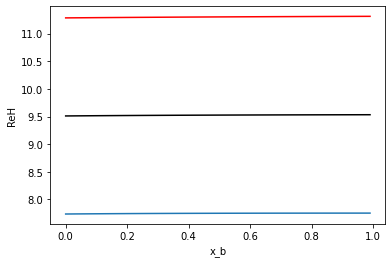

In [180]:
plt.plot(x, lower_y)
plt.plot(x, y, color='black')
plt.plot(x, upper_y, color='red')
plt.title('95% confidence interval with point predictions')
plt.ylabel("ReH")
plt.xlabel("x_b")
plt.show()

In [199]:
# def fitModelsReplicas(globalModel, X, y, numSets, numReplicas, results, whichCFF):
#     valid_error = 0

#     for i in range(numSets):
#         replica_models = []

#         valid_x = X[[i], :]
#         train_x = np.delete(X, 0, axis=0)
#         valid_y = np.array(y[i])

#         for rep in range(numReplicas):
#             train_y = np.delete(results[:, rep, whichCFF], i) #the training y is the only data that changes

#             thisModel = tf.keras.models.clone_model(globalModel)
#             thisModel.compile(optimizer=tf.keras.optimizers.Adam(.1), loss=tf.keras.losses.MeanSquaredError())
#             thisModel.fit(train_x, train_y, epochs = 150, verbose=0)
            
#             replica_models.append(thisModel)

#         print(valid_x)
#         guesses = produceEstimates(replica_models, valid_x)
#         print("Mean Estimate for set " + str(i) + ": " + str(guesses.mean()))
#         print("Sigma for set " + str(i) + ": " + str(guesses.std()))
#         print("Actual value for set " + str(i) + ": " + str(valid_y))
#         print("\n")
#         valid_error += np.square(guesses.mean() - valid_y)

#     print("Overall RMSE: " + str(np.sqrt(valid_error/numSets)))
    
#     replica_models = []
#     for rep in range(numReplicas):
#         train_y = results[:, rep, whichCFF]

#         thisModel = tf.keras.models.clone_model(globalModel)
#         thisModel.compile(optimizer=tf.keras.optimizers.Adam(.1), loss=tf.keras.losses.MeanSquaredError())
#         thisModel.fit(X, train_y, epochs = 150, verbose=0)

#         replica_models.append(thisModel)
            
#     return replica_models